# Image metadata

In [1]:
from wings.modeling.loss import DiceLoss
from wings.modeling.litnet import LitNet
from wings.config import PROCESSED_DATA_DIR, MODELS_DIR
import torch

mean_coords = torch.load(
    PROCESSED_DATA_DIR / "mask_datasets" / 'rectangle' / "mean_shape.pth", weights_only=False
)

checkpoint_path = MODELS_DIR / 'unet-rectangle-epoch=08-val_loss=0.14-unet-training-rectangle_1.ckpt'
unet_model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False
)
num_epochs = 60
model = LitNet.load_from_checkpoint(checkpoint_path, model=unet_model, num_epochs=num_epochs, criterion=DiceLoss())
model.eval()


2025-11-17 12:27:31.703 | INFO     | wings.config:<module>:40 - PROJ_ROOT path is: /home/mkrajew/bees
2025-11-17 12:27:32.150 | INFO     | wings.config:<module>:64 - torch.cuda.get_device_name()='NVIDIA RTX A3000 12GB Laptop GPU'
Using cache found in /home/mkrajew/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


LitNet(
  (model): UNet(
    (encoder1): Sequential(
      (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu1): ReLU(inplace=True)
      (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder2): Sequential(
      (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc2relu1): ReLU(inplace=True)
      (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm2): BatchNor

# PUŁAWY

## Collect data on how many coordinates each photo returns

In [2]:
from tqdm import tqdm
import os
from wings.config import RAW_DATA_DIR
from wings.gpa import recover_order, procrustes_align, normalize_shape, center_shape
from wings.visualizing.image_preprocess import unet_fit_rectangle_preprocess, final_coords
from wings.utils import load_image
from PIL import Image
import numpy as np
import torch

# Create lists to hold labels and indices for each point count (17–21)
original_labels = [[] for _ in range(5)]
points_indices = [[] for _ in range(5)]
group_photos_indices = []

directory = RAW_DATA_DIR / "pulawy" / "01_00_01"

all_files = []
for subdir, _, files in os.walk(directory):
    for file in files:
        if file.lower().endswith('.png'):
            all_files.append(os.path.join(subdir, file))

for idx, img_path in enumerate(tqdm(all_files, desc="Processing images")):
    image_tensor, x_size, y_size = load_image(img_path, unet_fit_rectangle_preprocess)

    if x_size == 5782:
        group_photos_indices.append(idx)
        continue

    img = Image.open(img_path)
    img.load()
    meta = img.info['IdentiFly']
    orig = meta.split("landmarks:")[1].split(";")[0]
    labels = [int(x) for x in orig.split()]
    coordinates = np.array(labels).reshape(-1, 2)
    coordinates[:, 1] = y_size - coordinates[:, 1] - 1

    output = model(image_tensor.cuda().unsqueeze(0))
    mask = torch.round(output).squeeze().detach().cpu().numpy()
    mask_coords = final_coords(mask, x_size, y_size)
    mask_coords = torch.tensor(mask_coords)

    n_points = len(mask_coords)
    # Determine index (0 → 17pts, 1 → 18pts, etc.)
    if n_points < 18:
        idx_group = 0
    elif n_points == 18:
        idx_group = 1
    elif n_points == 19:
        idx_group = 2
    elif n_points == 20:
        idx_group = 3
    else:
        idx_group = 4

    points_indices[idx_group].append(idx)
    original_labels[idx_group].append(coordinates)

# Convert to numpy arrays
original_labels = [np.stack(lbls) if len(lbls) > 0 else np.empty((0, 2)) for lbls in original_labels]

# Compute stats
total_samples_num = sum(len(p) for p in points_indices)
failed_samples_num = sum(len(points_indices[i]) for i in [0, 1, 3, 4])  # exclude 19-points group

all_indices = list(range(len(all_files)))
indices = [i for i in all_indices if i not in group_photos_indices]

print(f"Total samples: {total_samples_num}")
print(f"Failed masks: {failed_samples_num}")

# for i, n_points in enumerate(range(17, 22)):
#     print(f"{len(points_indices[i])=}")

for i, n_points in enumerate(range(17, 22)):
    print(f"points_indices[{n_points}]: {len(points_indices[i])}")


Processing images: 100%|██████████| 1092/1092 [01:05<00:00, 16.56it/s]

Total samples: 1012
Failed masks: 83
points_indices[17]: 1
points_indices[18]: 2
points_indices[19]: 929
points_indices[20]: 71
points_indices[21]: 9


## Handle incorrect number of landmarks

In [3]:
values = points_indices[0]
values_iter = iter(values)
max_n = len(values)
max_n


1

915 340
17


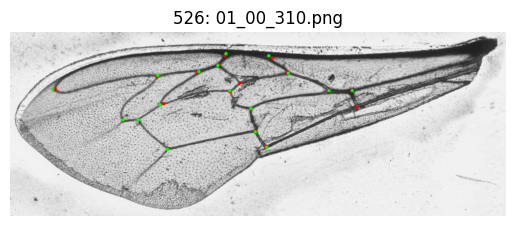

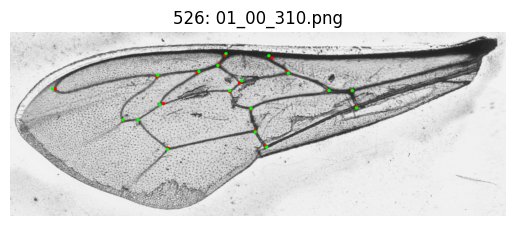

In [4]:
from pathlib import Path
from wings.visualizing.visualize import visualize_coords
from wings.visualizing.image_preprocess import final_coords
import cv2
import itertools

try:
    n = next(values_iter)
except StopIteration:
    values_iter = iter(values)
    n = next(values_iter)

img_path = all_files[n]
image_tensor, x_size, y_size = load_image(img_path, unet_fit_rectangle_preprocess)
print(x_size, y_size)

img = Image.open(img_path)
img.load()
meta = img.info['IdentiFly']
orig = meta.split("landmarks:")[1].split(";")[0]
labels = [int(x) for x in orig.split()]
coordinates = np.array(labels).reshape(-1, 2)
coordinates[:, 1] = y_size - coordinates[:, 1] - 1

img = cv2.imread(img_path, cv2.IMREAD_COLOR)
spot_size = 3
filename = Path(img_path).name
img = visualize_coords(img, coordinates.flatten(), spot_size=spot_size, color=(255, 0, 0), show=False)

output = model(image_tensor.cuda().unsqueeze(0))
mask = torch.round(output).squeeze().detach().cpu().numpy()
mask_coords = final_coords(mask, x_size, y_size)
mask_coords = torch.tensor(mask_coords)
idx = torch.randperm(mask_coords.size(0))
mask_coords = mask_coords[idx][:18]
print(len(mask_coords))
img = visualize_coords(img, mask_coords.flatten(), spot_size=spot_size, color=(0, 255, 0), filename=f"{n}: {filename}")
if len(mask_coords) == 19:
    reordered = recover_order(mean_coords, mask_coords)
elif len(mask_coords) > 19:
    extra_points = len(mask_coords) - len(mean_coords)
    best_loss = float('inf')
    best_coords = None

    if extra_points <= 3:
        for remove_idx in itertools.combinations(range(len(mask_coords)), extra_points):
            reduced = torch.stack(
                [p for i, p in enumerate(mask_coords) if i not in remove_idx]
            )
            reordered = recover_order(mean_coords, reduced)
            gpa = procrustes_align(normalize_shape(center_shape(reordered)), mean_coords)
            loss = torch.norm(gpa - mean_coords).item()
            if loss < best_loss:
                best_loss = loss
                best_coords = reduced
        mask_coords = best_coords
    else:
        mask_coords = mask_coords[:19]

elif len(mask_coords) <= 18:
    missing_points = len(mean_coords) - len(mask_coords)
    best_loss = float('inf')
    best_missing_idxs = None
    best_reordered = None
    best_temp_mean = None

    if missing_points <= 3:
        for remove_idx in itertools.combinations(range(len(mean_coords)), missing_points):
            temp_mean = torch.stack(
                [p for i, p in enumerate(mean_coords) if i not in remove_idx]
            )
            temp_mean_cn = normalize_shape(center_shape(temp_mean))
            reordered = recover_order(temp_mean_cn, mask_coords)
            gpa = procrustes_align(normalize_shape(center_shape(reordered)), temp_mean_cn)
            loss = torch.norm(gpa - temp_mean_cn).item()

            if loss < best_loss:
                best_loss = loss
                best_missing_idxs = remove_idx
                best_reordered = reordered
                best_temp_mean = temp_mean

        t_coords = best_reordered.mean(dim=0, keepdim=True)
        s_coords = torch.norm(center_shape(best_reordered))

        t_mean = best_temp_mean.mean(dim=0, keepdim=True)
        s_mean = torch.norm(center_shape(best_temp_mean))

        r = procrustes_align(
            normalize_shape(center_shape(best_reordered)),
            normalize_shape(center_shape(best_temp_mean)),
            only_matrix=True
        )

        mean_coords_temp = ((mean_coords - t_mean) / s_mean) @ r.T * s_coords + t_coords
        missing_points_tensor = mean_coords_temp[list(best_missing_idxs)]

        mask_coords = torch.cat([best_reordered, missing_points_tensor], dim=0)
    else:
        xmin, ymin = mask_coords.min(dim=0).values
        xmax, ymax = mask_coords.max(dim=0).values
        random_x = torch.empty(missing_points).uniform_(xmin.item(), xmax.item())
        random_y = torch.empty(missing_points).uniform_(ymin.item(), ymax.item())
        random_points = torch.stack([random_x, random_y], dim=1)
        mask_coords = torch.cat([mask_coords, random_points], dim=0)

reordered = recover_order(mean_coords, mask_coords)
img2 = visualize_coords(img, reordered.flatten(), spot_size=spot_size, color=(0, 255, 0), filename=f"{n}: {filename}")


In [16]:
def handle_coordinates(coords):
    mask_coords = coords.detach().clone()
    if len(mask_coords) > 19:
        extra_points = len(mask_coords) - len(mean_coords)
        best_loss = float('inf')
        best_coords = None

        if extra_points <= 3:
            for remove_idx in itertools.combinations(range(len(mask_coords)), extra_points):
                reduced = torch.stack(
                    [p for i, p in enumerate(mask_coords) if i not in remove_idx]
                )
                reordered = recover_order(mean_coords, reduced)
                gpa = procrustes_align(normalize_shape(center_shape(reordered)), mean_coords)
                loss = torch.norm(gpa - mean_coords).item()
                if loss < best_loss:
                    best_loss = loss
                    best_coords = reduced
            mask_coords = best_coords
        else:
            mask_coords = mask_coords[:19]

    elif len(mask_coords) <= 18:
        missing_points = len(mean_coords) - len(mask_coords)
        best_loss = float('inf')
        best_missing_idxs = None
        best_reordered = None
        best_temp_mean = None

        if missing_points <= 3:
            for remove_idx in itertools.combinations(range(len(mean_coords)), missing_points):
                temp_mean = torch.stack(
                    [p for i, p in enumerate(mean_coords) if i not in remove_idx]
                )
                temp_mean_cn = normalize_shape(center_shape(temp_mean))
                reordered = recover_order(temp_mean_cn, mask_coords)
                gpa = procrustes_align(normalize_shape(center_shape(reordered)), temp_mean_cn)
                loss = torch.norm(gpa - temp_mean_cn).item()

                if loss < best_loss:
                    best_loss = loss
                    best_missing_idxs = remove_idx
                    best_reordered = reordered
                    best_temp_mean = temp_mean

            t_coords = best_reordered.mean(dim=0, keepdim=True)
            s_coords = torch.norm(center_shape(best_reordered))

            t_mean = best_temp_mean.mean(dim=0, keepdim=True)
            s_mean = torch.norm(center_shape(best_temp_mean))

            r = procrustes_align(
                normalize_shape(center_shape(best_reordered)),
                normalize_shape(center_shape(best_temp_mean)),
                only_matrix=True
            )

            mean_coords_temp = ((mean_coords - t_mean) / s_mean) @ r.T * s_coords + t_coords
            missing_points_tensor = mean_coords_temp[list(best_missing_idxs)]

            mask_coords = torch.cat([best_reordered, missing_points_tensor], dim=0)
        else:
            xmin, ymin = mask_coords.min(dim=0).values
            xmax, ymax = mask_coords.max(dim=0).values
            random_x = torch.empty(missing_points).uniform_(xmin.item(), xmax.item())
            random_y = torch.empty(missing_points).uniform_(ymin.item(), ymax.item())
            random_points = torch.stack([random_x, random_y], dim=1)
            mask_coords = torch.cat([mask_coords, random_points], dim=0)

    reordered = recover_order(mean_coords, mask_coords)
    return reordered

## Calculate statistics

In [17]:
from tqdm import tqdm
from wings.config import RAW_DATA_DIR
from wings.visualizing.image_preprocess import unet_fit_rectangle_preprocess, final_coords
from wings.utils import load_image
import numpy as np
import torch

# Prepare lists for predicted labels for each point group (17–21)
predicted_labels = [[] for _ in range(5)]

directory = RAW_DATA_DIR / "pulawy" / "01_00_01"

for idx, img_path in enumerate(tqdm(all_files, desc="Processing images")):
    if idx not in indices:
        continue

    image_tensor, x_size, y_size = load_image(img_path, unet_fit_rectangle_preprocess)
    output = model(image_tensor.cuda().unsqueeze(0))
    mask = torch.round(output).squeeze().detach().cpu().numpy()
    mask_coords = final_coords(mask, x_size, y_size)
    mask_coords = torch.tensor(mask_coords)
    n_points = len(mask_coords)

    if n_points < 18:
        idx_group = 0
    elif n_points == 18:
        idx_group = 1
    elif n_points == 19:
        idx_group = 2
    elif n_points == 20:
        idx_group = 3
    else:
        idx_group = 4

    reordered = handle_coordinates(mask_coords).cpu().numpy()
    predicted_labels[idx_group].append(reordered)

# Convert lists to numpy arrays (empty arrays if no samples)
predicted_labels = [
    np.stack(lbls) if len(lbls) > 0 else np.empty((0, 0, 2)) for lbls in predicted_labels
]

# Print shapes for verification
for i, n_points in enumerate(range(17, 22)):
    print(f"{predicted_labels[i].shape=}")


Processing images: 100%|██████████| 1092/1092 [00:12<00:00, 85.67it/s] 

predicted_labels[i].shape=(1, 19, 2)
predicted_labels[i].shape=(2, 19, 2)
predicted_labels[i].shape=(929, 19, 2)
predicted_labels[i].shape=(71, 19, 2)
predicted_labels[i].shape=(9, 19, 2)


## Errors

In [18]:
import numpy as np

# Compute per-group Euclidean errors
errors = []
for i in range(5):
    if len(predicted_labels[i]) == 0 or len(original_labels[i]) == 0:
        errors.append(np.empty((0, 0)))
        continue
    err = np.linalg.norm(predicted_labels[i] - original_labels[i], axis=2)
    errors.append(err)

# Compute means and medians
for i, n_points in enumerate(range(17, 22)):
    if errors[i].size == 0:
        print(f"{n_points}-point group: no samples available.")
        continue
    mean_val = errors[i].mean()
    median_val = np.median(errors[i])
    num_img = len(errors[i])  # total number of point-wise errors

    print(f"mean{n_points}={mean_val:.4f}\tmedian{n_points}={median_val:.4f}\t\timages={num_img}")

# ---- GLOBAL ERROR ACROSS ALL GROUPS ----
# Flatten all non-empty error arrays into a single array
all_errors = np.concatenate([e.flatten() for e in errors if e.size > 0])

if all_errors.size > 0:
    global_mean = all_errors.mean()
    global_median = np.median(all_errors)
    print(f"\nGLOBAL MEAN ERROR = {global_mean:.4f}")
    print(f"GLOBAL MEDIAN ERROR = {global_median:.4f}")
else:
    print("\nNo valid error data available for global computation.")


mean17=3.0218	median17=2.6425		images=1
mean18=2.9563	median18=2.2694		images=2
mean19=2.7280	median19=2.1828		images=929
mean20=2.6890	median20=2.1231		images=71
mean21=2.6607	median21=2.2247		images=9

GLOBAL MEAN ERROR = 2.7254
GLOBAL MEDIAN ERROR = 2.1786


# Test dataset

In [19]:
test_dataset = torch.load(
    PROCESSED_DATA_DIR / "mask_datasets" / 'rectangle' / "test_mask_dataset.pth",
    weights_only=False
)
max_n = len(test_dataset)


In [20]:
from wings.gpa import recover_order, center_shape, normalize_shape, procrustes_align
from wings.visualizing.image_preprocess import final_coords
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

original_labels = [[] for _ in range(5)]
predicted_labels = [[] for _ in range(5)]
points_indices = [[] for _ in range(5)]

for idx, (image, _, coords, (x_size, y_size)) in enumerate(tqdm(test_dataset, desc="Evaluating")):
    image = image.to(device).unsqueeze(0)
    output = model(image)
    mask = torch.round(output).squeeze().detach().cpu().numpy()
    mask_coords = final_coords(mask, x_size, y_size)
    mask_coords = torch.tensor(mask_coords)
    n_points = len(mask_coords)

    if n_points < 18:
        idx_group = 0
    elif n_points == 18:
        idx_group = 1
    elif n_points == 19:
        idx_group = 2
    elif n_points == 20:
        idx_group = 3
    else:
        idx_group = 4

    reordered = handle_coordinates(mask_coords).cpu().numpy()
    orig = coords.view(-1, 2)

    points_indices[idx_group].append(idx)
    original_labels[idx_group].append(orig.cpu().numpy())
    predicted_labels[idx_group].append(reordered)



original_labels = [np.stack(lbls) if len(lbls) > 0 else np.empty((0, 2)) for lbls in original_labels]
predicted_labels = [
    np.stack(lbls) if len(lbls) > 0 else np.empty((0, 0, 2)) for lbls in predicted_labels
]


total_samples_num = len(test_dataset)
failed_samples_num = sum(len(points_indices[i]) for i in [0, 1, 3, 4])  # exclude 19-points group

print(f"Total samples: {total_samples_num}")
print(f"Failed masks: {failed_samples_num}")

for i, n_points in enumerate(range(17, 22)):
    print(f"predicted_labels_{n_points}.shape = {predicted_labels[i].shape}")


Evaluating: 100%|██████████| 2172/2172 [00:31<00:00, 69.21it/s]

Total samples: 2172
Failed masks: 37
predicted_labels_17.shape = (1, 19, 2)
predicted_labels_18.shape = (20, 19, 2)
predicted_labels_19.shape = (2135, 19, 2)
predicted_labels_20.shape = (13, 19, 2)
predicted_labels_21.shape = (3, 19, 2)


In [23]:
errors = []
for i in range(5):
    if len(predicted_labels[i]) == 0 or len(original_labels[i]) == 0:
        errors.append(np.empty((0, 0)))
        continue
    err = np.linalg.norm(predicted_labels[i] - original_labels[i], axis=2)
    errors.append(err)

# Compute means and medians
for i, n_points in enumerate(range(17, 22)):
    if errors[i].size == 0:
        print(f"{n_points}-point group: no samples available.")
        continue
    mean_val = errors[i].mean()
    median_val = np.median(errors[i])
    num_img = len(errors[i])  # total number of point-wise errors

    print(f"mean{n_points}={mean_val:.4f}\tmedian{n_points}={median_val:.4f}\t\timages={num_img}")



# ---- GLOBAL ERROR ACROSS ALL GROUPS ----
# Flatten all non-empty error arrays into a single array
all_errors = np.concatenate([e.flatten() for e in errors if e.size > 0])

if all_errors.size > 0:
    global_mean = all_errors.mean()
    global_median = np.median(all_errors)
    print(f"\nGLOBAL MEAN ERROR = {global_mean:.4f}")
    print(f"GLOBAL MEDIAN ERROR = {global_median:.4f}")
else:
    print("\nNo valid error data available for global computation.")

mean17=1.2663	median17=1.2583		images=1
mean18=2.3212	median18=1.9915		images=20
mean19=1.8126	median19=1.6827		images=2135
mean20=2.0388	median20=1.8834		images=13
mean21=30.1173	median21=2.4538		images=3

GLOBAL MEAN ERROR = 1.8575
GLOBAL MEDIAN ERROR = 1.6853


# Visualize

In [37]:
values = points_indices[0]
values_iter = iter(values)
max_n = len(values)
max_n


13

20


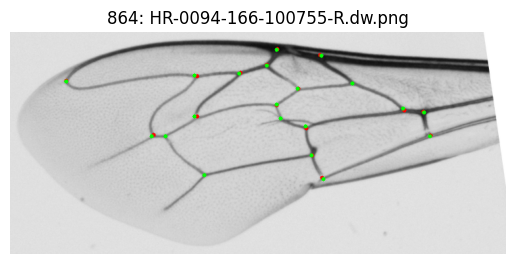

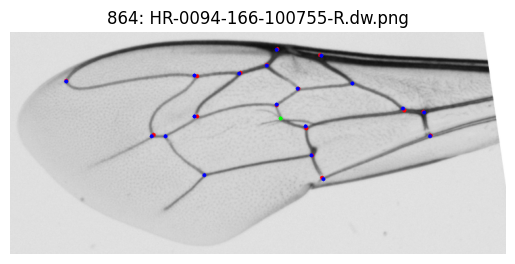

In [44]:
from wings.config import IMG_FOLDER_SUFX
from pathlib import Path
from wings.visualizing.visualize import visualize_coords
from wings.visualizing.image_preprocess import final_coords
import cv2
import itertools

try:
    n = next(values_iter)
except StopIteration:
    values_iter = iter(values)
    n = next(values_iter)


image, _, coords, (x_size, y_size) = test_dataset[n]
orig = coords.view(-1, 2)

image = image.to(device).unsqueeze(0)
output = model(image)
mask = torch.round(output).squeeze().detach().cpu().numpy()
mask_coords = final_coords(mask, x_size, y_size)
mask_coords = torch.tensor(mask_coords)
print(len(mask_coords))
reordered = handle_coordinates(mask_coords).cpu().numpy()

original_dataset = test_dataset.dataset  # this gives you the original dataset
filename = original_dataset.coords_df.loc[test_dataset.indices[n], 'file']
country = filename.split('-', 1)[0]
filepath = RAW_DATA_DIR / f"{country}{IMG_FOLDER_SUFX}" / filename
img = cv2.imread(filepath, cv2.IMREAD_COLOR)
spot_size = 3
img = visualize_coords(img, orig.flatten(), spot_size=spot_size, color=(255, 0, 0), show=False)
img = visualize_coords(img, mask_coords.flatten(), spot_size=spot_size, color=(0, 255, 0), filename=f"{n}: {filename}")
img2 = visualize_coords(img, reordered.flatten(), spot_size=spot_size, color=(0, 0, 255), filename=f"{n}: {filename}")


# Random statistics

In [45]:
from wings.gpa import recover_order, center_shape, normalize_shape, procrustes_align
from wings.visualizing.image_preprocess import final_coords
import torch
import random
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

original_labels = [[] for _ in range(5)]
predicted_labels = [[] for _ in range(5)]
points_indices = [[] for _ in range(5)]

for idx, (image, _, coords, (x_size, y_size)) in enumerate(tqdm(test_dataset, desc="Evaluating")):
    image = image.to(device).unsqueeze(0)
    output = model(image)
    mask = torch.round(output).squeeze().detach().cpu().numpy()
    mask_coords = final_coords(mask, x_size, y_size)
    mask_coords = torch.tensor(mask_coords)

    target_n = random.randint(16, 22)
    current_n = mask_coords.shape[0]

    if target_n < current_n:
        indices_to_keep = torch.randperm(current_n)[:target_n]
        mask_coords = mask_coords[indices_to_keep]
    elif target_n > current_n:
        n_to_add = target_n - current_n
        new_points = torch.stack([
            torch.randint(0, x_size, (n_to_add,)),
            torch.randint(0, y_size, (n_to_add,))
        ], dim=1)
        mask_coords = torch.cat([mask_coords, new_points], dim=0)


    n_points = len(mask_coords)

    if n_points < 18:
        idx_group = 0
    elif n_points == 18:
        idx_group = 1
    elif n_points == 19:
        idx_group = 2
    elif n_points == 20:
        idx_group = 3
    else:
        idx_group = 4

    reordered = handle_coordinates(mask_coords).cpu().numpy()
    orig = coords.view(-1, 2)

    points_indices[idx_group].append(idx)
    original_labels[idx_group].append(orig.cpu().numpy())
    predicted_labels[idx_group].append(reordered)



original_labels = [np.stack(lbls) if len(lbls) > 0 else np.empty((0, 2)) for lbls in original_labels]
predicted_labels = [
    np.stack(lbls) if len(lbls) > 0 else np.empty((0, 0, 2)) for lbls in predicted_labels
]


total_samples_num = len(test_dataset)
failed_samples_num = sum(len(points_indices[i]) for i in [0, 1, 3, 4])  # exclude 19-points group

print(f"Total samples: {total_samples_num}")
print(f"Failed masks: {failed_samples_num}")

for i, n_points in enumerate(range(17, 22)):
    print(f"predicted_labels_{n_points}.shape = {predicted_labels[i].shape}")


Evaluating: 100%|██████████| 2172/2172 [06:57<00:00,  5.21it/s]

Total samples: 2172
Failed masks: 1868
predicted_labels_17.shape = (596, 19, 2)
predicted_labels_18.shape = (316, 19, 2)
predicted_labels_19.shape = (304, 19, 2)
predicted_labels_20.shape = (330, 19, 2)
predicted_labels_21.shape = (626, 19, 2)


In [46]:
errors = []
for i in range(5):
    if len(predicted_labels[i]) == 0 or len(original_labels[i]) == 0:
        errors.append(np.empty((0, 0)))
        continue
    err = np.linalg.norm(predicted_labels[i] - original_labels[i], axis=2)
    errors.append(err)

# Compute means and medians
for i, n_points in enumerate(range(17, 22)):
    if errors[i].size == 0:
        print(f"{n_points}-point group: no samples available.")
        continue
    mean_val = errors[i].mean()
    median_val = np.median(errors[i])
    num_img = len(errors[i])  # total number of point-wise errors

    print(f"mean{n_points}={mean_val:.4f}\tmedian{n_points}={median_val:.4f}\t\timages={num_img}")



# ---- GLOBAL ERROR ACROSS ALL GROUPS ----
# Flatten all non-empty error arrays into a single array
all_errors = np.concatenate([e.flatten() for e in errors if e.size > 0])

if all_errors.size > 0:
    global_mean = all_errors.mean()
    global_median = np.median(all_errors)
    print(f"\nGLOBAL MEAN ERROR = {global_mean:.4f}")
    print(f"GLOBAL MEDIAN ERROR = {global_median:.4f}")
else:
    print("\nNo valid error data available for global computation.")

mean17=2.0527	median17=1.7631		images=596
mean18=2.2005	median18=1.7484		images=316
mean19=1.9049	median19=1.6880		images=304
mean20=1.9855	median20=1.7275		images=330
mean21=1.9672	median21=1.6743		images=626

GLOBAL MEAN ERROR = 2.0187
GLOBAL MEDIAN ERROR = 1.7185
